In [1]:
# Setup
import sys
sys.path.append('../..')

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

import xfads.utils as utils
import xfads.plot_utils as plot_utils
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL

# Our custom modules
from regularized_ssm import RegularizedSSM, create_rotation_vector_field
from loss_analysis_utils import (
    LossComponentAnalyzer, 
    RegularizationStrengthAnalyzer,
    create_perfect_rotation_test
)
from regularizers import LieDerivativeRegularizer

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


## 🎯 Step 1: Create Simple Test System

We'll create a minimal system to isolate the effects of regularization.

In [2]:
# Simple configuration
class SimpleConfig:
    n_latents = 2
    n_latents_read = 2  
    n_hidden_dynamics = 32
    n_hidden_local = 32
    n_hidden_backward = 32
    rank_local = 2
    rank_backward = 2
    p_local_dropout = 0.0
    n_samples = 10
    batch_sz = 32
    seed = 42

cfg = SimpleConfig()

# Create simple synthetic data
n_trials = 200
n_neurons = 20
n_time_bins = 30

print(f"Creating simple test system:")
print(f"  {n_trials} trials × {n_time_bins} time bins × {n_neurons} neurons")
print(f"  {cfg.n_latents}D latent space")

Creating simple test system:
  200 trials × 30 time bins × 20 neurons
  2D latent space


In [3]:
# Create perfect rotation dynamics for ground truth
def perfect_rotation_dynamics(x, speed=1.0):
    """Perfect rotation: F(x) = speed * [-y, x]"""
    if x.dim() == 1:
        return speed * torch.tensor([-x[1], x[0]], device=x.device, dtype=x.dtype)
    else:
        return speed * torch.stack([-x[..., 1], x[..., 0]], dim=-1)

class PerfectRotationDynamics(nn.Module):
    def __init__(self, speed=0.5):
        super().__init__()
        self.speed = speed
        
    def forward(self, x):
        return perfect_rotation_dynamics(x, self.speed)

# Generate data from perfect rotation
true_dynamics = PerfectRotationDynamics(speed=0.5).to(device)
target_field = create_rotation_vector_field(rotation_speed=0.5)  # Same as true dynamics

# Create observation matrix
C = utils.FanInLinear(cfg.n_latents, n_neurons, device=device).requires_grad_(False)

# Noise parameters
Q_diag = 1e-3 * torch.ones(cfg.n_latents, device=device)  # Small process noise
Q_0_diag = 0.5 * torch.ones(cfg.n_latents, device=device)
R_diag = 1e-2 * torch.ones(n_neurons, device=device)  # Small observation noise
m_0 = torch.zeros(cfg.n_latents, device=device)

print("Generating data from perfect rotation dynamics...")
z_true = utils.sample_gauss_z(true_dynamics, Q_diag, m_0, Q_0_diag, n_trials, n_time_bins)
y = C(z_true) + torch.sqrt(R_diag) * torch.randn((n_trials, n_time_bins, n_neurons), device=device)
y = y.detach()

print(f"✅ Data generated:")
print(f"   True latents: {z_true.shape}")
print(f"   Observations: {y.shape}")

Generating data from perfect rotation dynamics...
✅ Data generated:
   True latents: torch.Size([200, 30, 2])
   Observations: torch.Size([200, 30, 20])


## 📊 Step 2: Visualize True Dynamics and Target Field

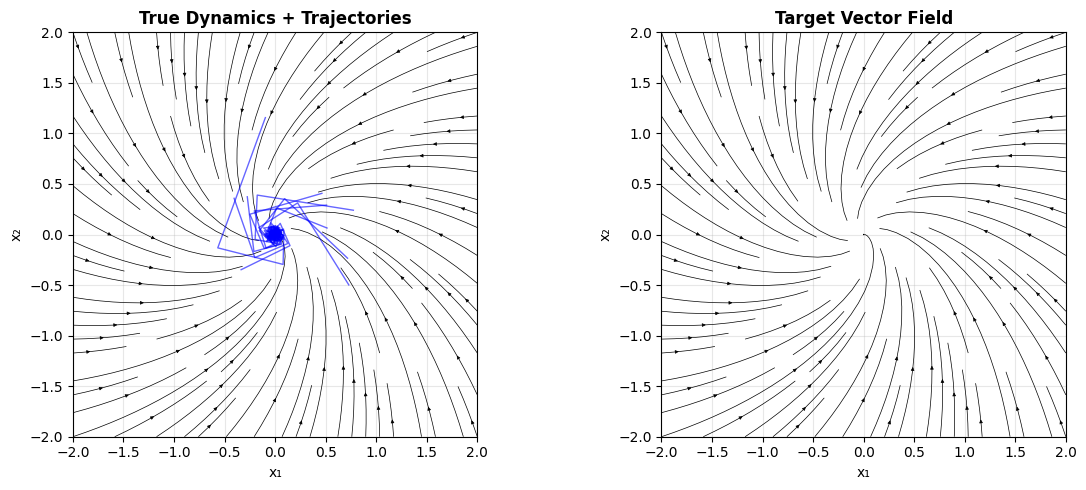

📊 True dynamics and target field are identical (perfect rotation)
📊 Goal: Find λ such that learned F matches this perfectly


In [4]:
# Visualize true dynamics and target field
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# True dynamics + trajectories
plot_utils.plot_two_d_vector_field(true_dynamics.to('cpu'), axes[0], min_xy=-2, max_xy=2)
for i in range(10):
    axes[0].plot(z_true[i, :, 0].cpu(), z_true[i, :, 1].cpu(), 'b-', alpha=0.6, linewidth=1)
axes[0].set_title('True Dynamics + Trajectories', fontweight='bold')
axes[0].set_xlabel('x₁')
axes[0].set_ylabel('x₂')
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-2, 2)
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Target field (should be identical)
plot_utils.plot_two_d_vector_field(
    lambda x: target_field(x), axes[1], min_xy=-2, max_xy=2
)
axes[1].set_title('Target Vector Field', fontweight='bold')
axes[1].set_xlabel('x₁')
axes[1].set_ylabel('x₂')
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('true_vs_target_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 True dynamics and target field are identical (perfect rotation)")
print("📊 Goal: Find λ such that learned F matches this perfectly")

## 🏗️ Step 3: Create SSM Factory Function

This function creates a RegularizedSSM with different λ values for testing.

In [5]:
def create_regularized_ssm(lambda_lie=1.0, lambda_curvature=0.0):
    """Factory function to create RegularizedSSM with given parameters."""
    
    # Likelihood
    H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
    readout_fn = nn.Sequential(H, C)
    likelihood_pdf = GaussianLikelihood(readout_fn, n_neurons, R_diag, device=device, fix_R=True)

    # Learnable dynamics (this is what we want to regularize)
    dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=device)
    dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=device)

    # Initial condition
    initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=device)

    # Encoders
    backward_encoder = BackwardEncoderLRMvn(
        cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=device
    )
    local_encoder = LocalEncoderLRMvn(
        cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents,
        rank=cfg.rank_local, device=device, dropout=cfg.p_local_dropout
    )

    # Nonlinear filtering
    nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=device)

    # Create regularized SSM
    regularized_ssm = RegularizedSSM(
        dynamics_mod=dynamics_mod,
        likelihood_pdf=likelihood_pdf,
        initial_c_pdf=initial_condition_pdf,
        backward_encoder=backward_encoder,
        local_encoder=local_encoder,
        nl_filter=nl_filter,
        target_vector_field=target_field,
        lambda_lie=lambda_lie,
        lambda_curvature=lambda_curvature,
        lie_normalize="yang",
        device=device
    )
    
    return regularized_ssm

# Test the factory
test_ssm = create_regularized_ssm(lambda_lie=1.0)
print(f"✅ SSM factory created successfully")
print(f"   Parameters: {sum(p.numel() for p in test_ssm.parameters())}")

✅ SSM factory created successfully
   Parameters: 8400


## 🔬 Step 4: Analyze Untrained Model

Let's see what the loss components look like before any training.

🔬 Analyzing untrained models with different λ values...

λ =    0.0: Total = 1002.128, ELBO = 1002.128, Lie =    0.000
λ =    0.1: Total = 3099.970, ELBO =  470.168, Lie = 26298.016
λ =    1.0: Total = 39379.438, ELBO =  731.842, Lie = 38647.594
λ =   10.0: Total = 433473.656, ELBO =  928.602, Lie = 43254.508
λ =  100.0: Total = 17478574.000, ELBO =  256.773, Lie = 174783.188


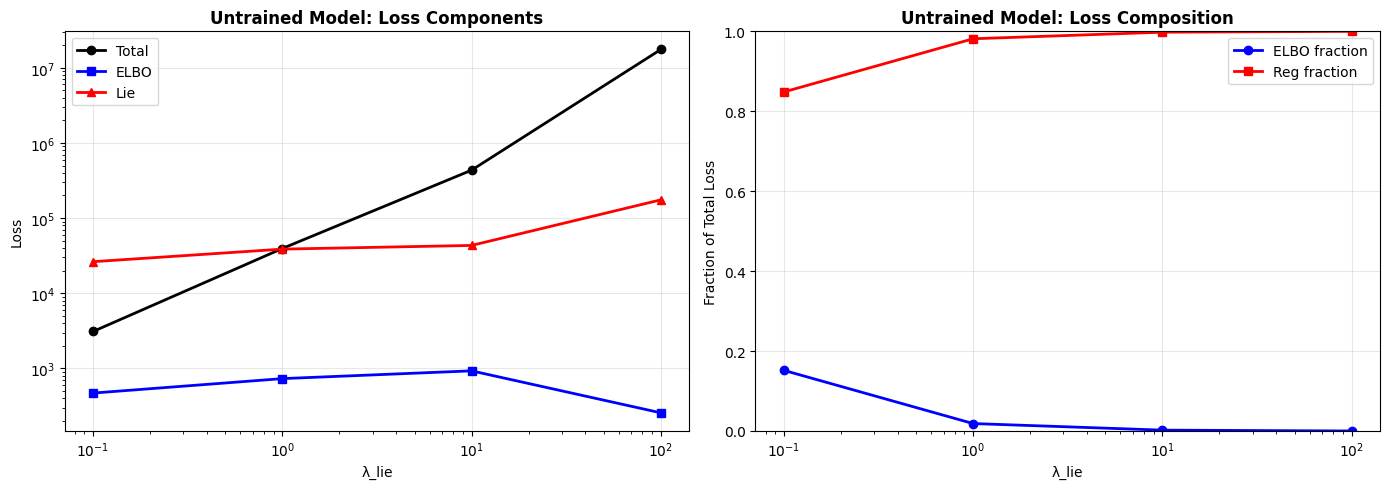


📊 Key observations:
   - ELBO loss is independent of λ (as expected for untrained model)
   - Lie loss scales with λ due to random initialization
   - Need λ ≥ 1 for regularization to have significant effect


In [7]:
# Test different lambda values on untrained models
lambda_values = [0.0, 0.1, 1.0, 10.0, 100.0]

print("🔬 Analyzing untrained models with different λ values...\n")

untrained_results = []
for lambda_lie in lambda_values:
    ssm = create_regularized_ssm(lambda_lie=lambda_lie)
    analyzer = LossComponentAnalyzer(ssm, device=device)
    
    # Evaluate on small batch to avoid memory issues
    losses = analyzer.evaluate_loss_components(y[:50], n_samples=5)
    
    result = {'lambda_lie': lambda_lie, **losses}
    untrained_results.append(result)
    
    print(f"λ = {lambda_lie:6.1f}: Total = {losses['total_loss']:8.3f}, ELBO = {losses['elbo_loss']:8.3f}, Lie = {losses['lie_loss']:8.3f}")

# Convert to DataFrame for plotting
df_untrained = pd.DataFrame(untrained_results)

# Plot untrained results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss components
ax = axes[0]
ax.loglog(df_untrained['lambda_lie'][1:], df_untrained['total_loss'][1:], 'k-o', label='Total', linewidth=2)
ax.loglog(df_untrained['lambda_lie'][1:], df_untrained['elbo_loss'][1:], 'b-s', label='ELBO', linewidth=2)
ax.loglog(df_untrained['lambda_lie'][1:], df_untrained['lie_loss'][1:], 'r-^', label='Lie', linewidth=2)
ax.set_xlabel('λ_lie')
ax.set_ylabel('Loss')
ax.set_title('Untrained Model: Loss Components', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Loss composition
ax = axes[1]
elbo_fraction = df_untrained['elbo_loss'] / df_untrained['total_loss']
reg_fraction = df_untrained['total_reg_loss'] / df_untrained['total_loss']
ax.semilogx(df_untrained['lambda_lie'][1:], elbo_fraction[1:], 'b-o', label='ELBO fraction', linewidth=2)
ax.semilogx(df_untrained['lambda_lie'][1:], reg_fraction[1:], 'r-s', label='Reg fraction', linewidth=2)
ax.set_xlabel('λ_lie')
ax.set_ylabel('Fraction of Total Loss')
ax.set_title('Untrained Model: Loss Composition', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('untrained_lambda_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Key observations:")
print(f"   - ELBO loss is independent of λ (as expected for untrained model)")
print(f"   - Lie loss scales with λ due to random initialization")
print(f"   - Need λ ≥ 1 for regularization to have significant effect")

## 🚀 Step 5: Quick Training with Different λ Values

Let's do very short training runs to see how regularization affects learning.

In [8]:
def quick_train_ssm(ssm, y_data, n_epochs=10, lr=1e-3):
    """Quick training function for analysis."""
    optimizer = torch.optim.Adam(ssm.parameters(), lr=lr)
    
    # Split data
    n_train = int(0.8 * len(y_data))
    y_train = y_data[:n_train]
    y_valid = y_data[n_train:]
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(n_epochs):
        # Training
        ssm.train()
        optimizer.zero_grad()
        
        # Use smaller batches
        batch_size = 16
        indices = torch.randperm(len(y_train))[:batch_size]
        y_batch = y_train[indices]
        
        loss, _, stats = ssm(y_batch, cfg.n_samples)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(ssm.parameters(), 1.0)
        optimizer.step()
        
        # Validation (every few epochs)
        if epoch % 3 == 0:
            ssm.eval()
            with torch.no_grad():
                val_loss, _, val_stats = ssm(y_valid[:16], cfg.n_samples)
            
            train_losses.append({
                'epoch': epoch,
                'total_loss': loss.item(),
                'elbo_loss': stats['elbo_loss'].item(),
                'lie_loss': stats['lie_loss'].item()
            })
            
    return train_losses

# Test different lambda values with quick training
lambda_test_values = [0.1, 1.0, 10.0]
training_results = {}

print("🚀 Quick training with different λ values...\n")

for lambda_lie in lambda_test_values:
    print(f"Training with λ = {lambda_lie}...")
    
    ssm = create_regularized_ssm(lambda_lie=lambda_lie)
    losses = quick_train_ssm(ssm, y, n_epochs=15, lr=5e-4)
    training_results[lambda_lie] = {
        'losses': losses,
        'final_ssm': ssm
    }
    
    if losses:
        final_loss = losses[-1]
        print(f"   Final - Total: {final_loss['total_loss']:.3f}, ELBO: {final_loss['elbo_loss']:.3f}, Lie: {final_loss['lie_loss']:.3f}")
    
print("\n✅ Quick training completed!")

🚀 Quick training with different λ values...

Training with λ = 0.1...
   Final - Total: 3706.992, ELBO: 576.654, Lie: 31303.379
Training with λ = 1.0...
   Final - Total: 14525.779, ELBO: 534.005, Lie: 13991.773
Training with λ = 10.0...
   Final - Total: 21654.111, ELBO: 541.240, Lie: 2111.287

✅ Quick training completed!


## 📈 Step 6: Visualize Training Progress

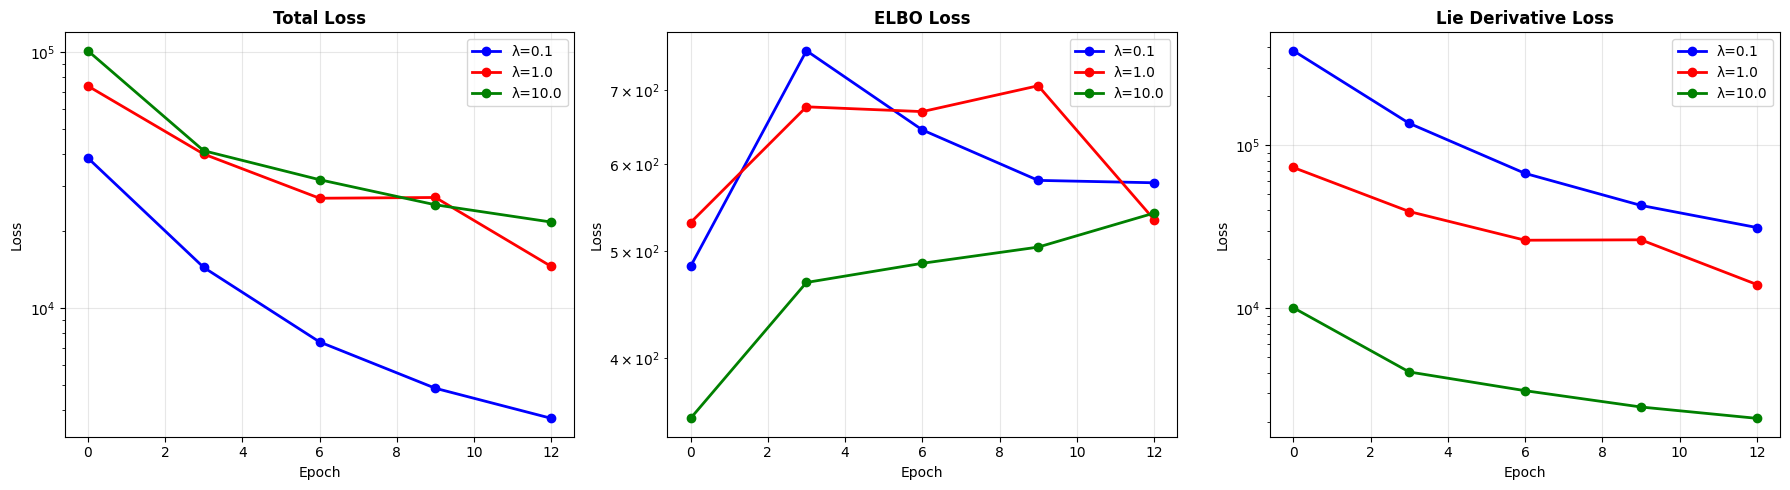

📈 Training curves show how different λ values affect learning dynamics


In [11]:
# Plot training curves for different lambda values
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['blue', 'red', 'green']

for i, (lambda_lie, color) in enumerate(zip(lambda_test_values, colors)):
    losses = training_results[lambda_lie]['losses']
    if not losses:
        continue
        
    df_train = pd.DataFrame(losses)
    
    # Total loss
    axes[0].semilogy(df_train['epoch'], df_train['total_loss'], 
                    '-o', color=color, label=f'λ={lambda_lie}', linewidth=2)
    
    # ELBO loss  
    axes[1].semilogy(df_train['epoch'], df_train['elbo_loss'], 
                    '-o', color=color, label=f'λ={lambda_lie}', linewidth=2)
    
    # Lie loss
    axes[2].semilogy(df_train['epoch'], df_train['lie_loss'], 
                    '-o', color=color, label=f'λ={lambda_lie}', linewidth=2)

axes[0].set_title('Total Loss', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('ELBO Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].set_title('Lie Derivative Loss', fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_by_lambda.png', dpi=300, bbox_inches='tight')
plt.show()

print("📈 Training curves show how different λ values affect learning dynamics")

## 🎯 Step 7: Spatial Analysis of Perfect Symmetry

Let's see where in space the symmetry is violated and how well we achieve perfect rotation.

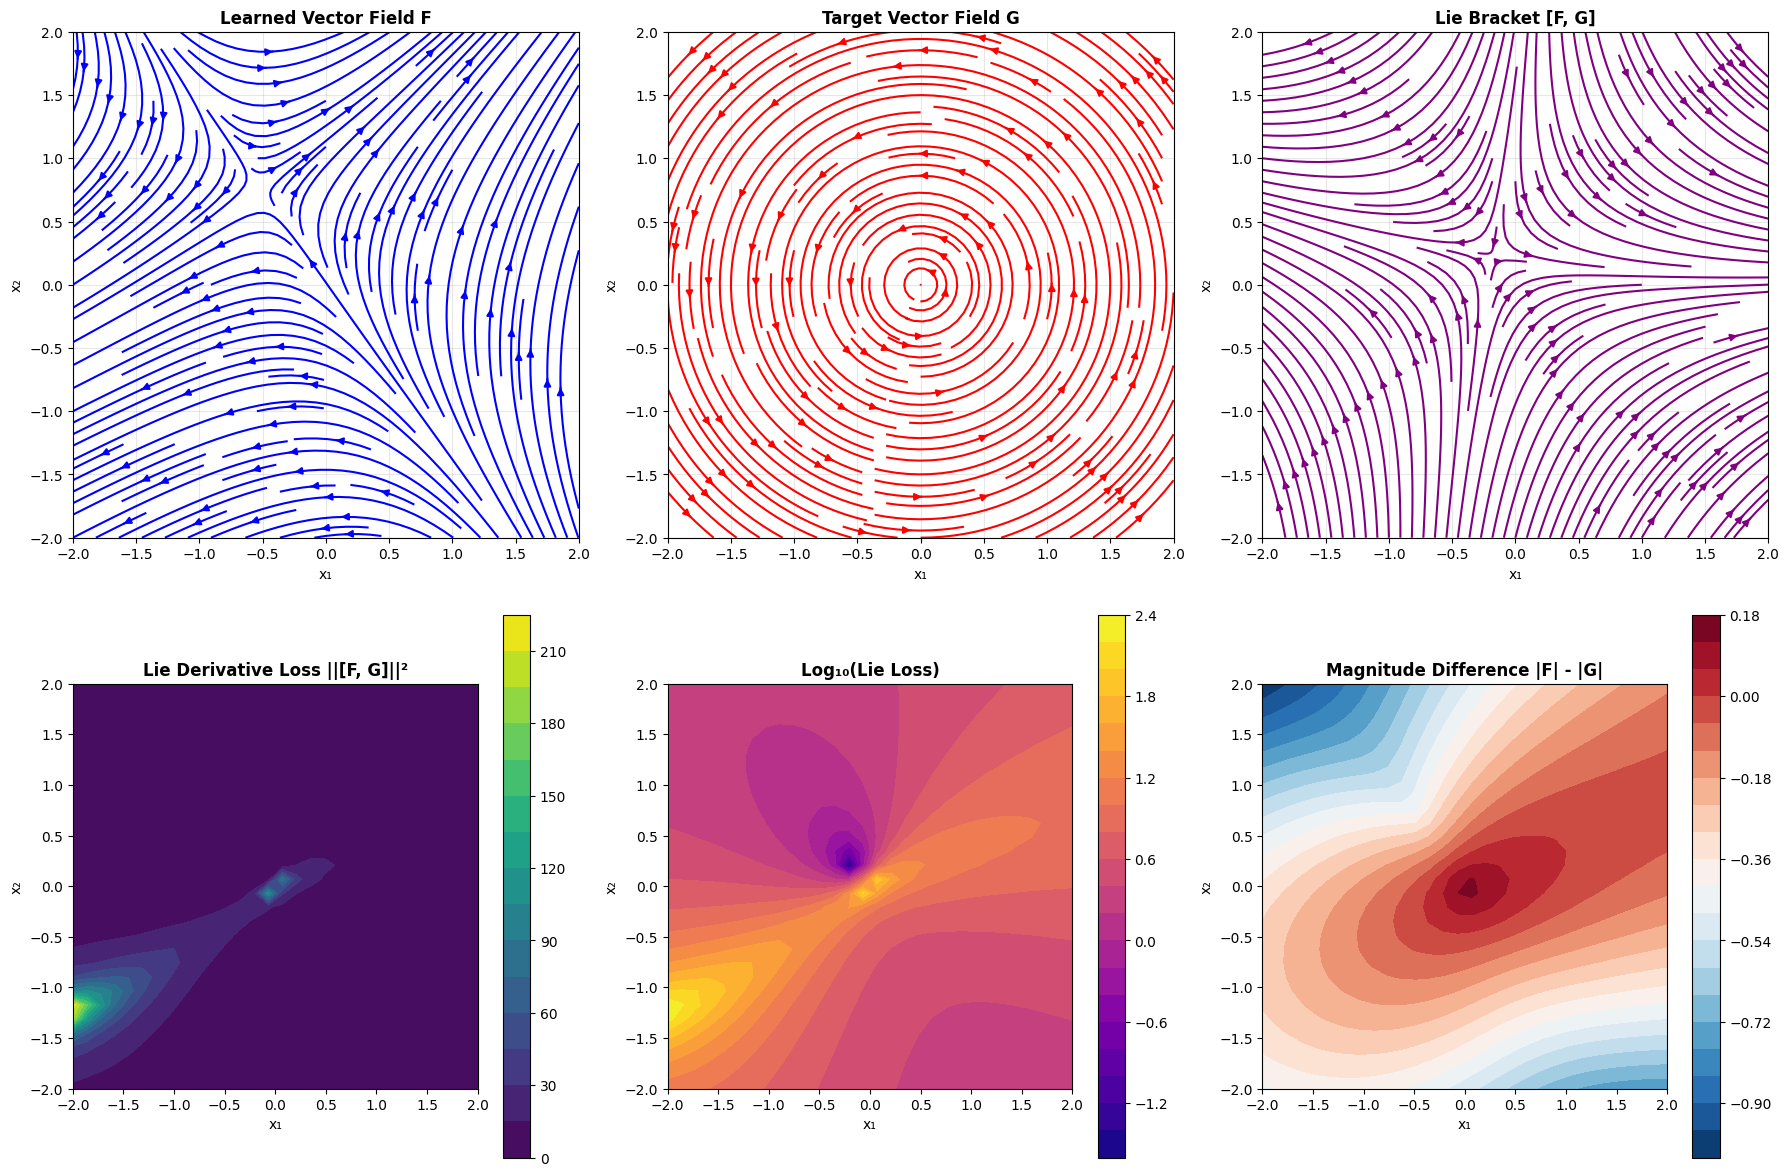

🎯 Spatial analysis for λ = 10.0:
   Max Lie loss: 218.416870
   Mean Lie loss: 8.362527
   Min Lie loss: 0.031951


In [14]:
# Choose the best lambda from training
best_lambda = 10.0  # Adjust based on training results
best_ssm = training_results[best_lambda]['final_ssm']
best_ssm.eval()

# Create analyzer and do spatial analysis
analyzer = LossComponentAnalyzer(best_ssm, device=device)
spatial_data = analyzer.analyze_lie_derivative_spatial(grid_size=30, domain=(-2, 2))

# Plot spatial analysis
fig = analyzer.plot_spatial_analysis(spatial_data, save_path='spatial_symmetry_analysis.png')
plt.show()

print(f"🎯 Spatial analysis for λ = {best_lambda}:")
print(f"   Max Lie loss: {spatial_data['lie_loss'].max():.6f}")
print(f"   Mean Lie loss: {spatial_data['lie_loss'].mean():.6f}")
print(f"   Min Lie loss: {spatial_data['lie_loss'].min():.6f}")

## 🔍 Step 8: Perfect Rotation Test

Test how well our learned dynamics satisfies perfect rotation symmetry.

In [15]:
# Create perfect rotation test
test_points, rotation_field, evaluate_rotation_symmetry = create_perfect_rotation_test()

print("🔍 Perfect Rotation Symmetry Test\n")

for lambda_lie in lambda_test_values:
    ssm = training_results[lambda_lie]['final_ssm']
    
    # Evaluate rotation symmetry
    symmetry_results = evaluate_rotation_symmetry(
        ssm.dynamics_mod.mean_fn, 
        rotation_field, 
        test_points
    )
    
    print(f"λ = {lambda_lie:4.1f}: Max violation = {symmetry_results['max_violation']:.6f}, Mean = {symmetry_results['mean_violation']:.6f}")

# Test the true dynamics as reference
true_symmetry = evaluate_rotation_symmetry(
    true_dynamics, rotation_field, test_points
)
print(f"True dynamics: Max violation = {true_symmetry['max_violation']:.6f}, Mean = {true_symmetry['mean_violation']:.6f}")

print(f"\n🎯 Goal: Get learned dynamics as close to true dynamics as possible")
print(f"   Perfect symmetry means violation ≈ 0 (numerical precision limit ~1e-7)")

🔍 Perfect Rotation Symmetry Test

λ =  0.1: Max violation = 0.428234, Mean = 0.136245
λ =  1.0: Max violation = 0.694917, Mean = 0.234993
λ = 10.0: Max violation = 2.123166, Mean = 0.665090
True dynamics: Max violation = 0.000000, Mean = 0.000000

🎯 Goal: Get learned dynamics as close to true dynamics as possible
   Perfect symmetry means violation ≈ 0 (numerical precision limit ~1e-7)


## 📊 Step 9: Comprehensive Lambda Sweep

Do a comprehensive sweep to find the optimal λ range.

📊 Comprehensive λ sweep: 20 values from 0.010 to 1000.0
Testing λ_lie = 0.01
Testing λ_lie = 0.018329807108324356
Testing λ_lie = 0.03359818286283781
Testing λ_lie = 0.06158482110660264
Testing λ_lie = 0.11288378916846889
Testing λ_lie = 0.20691380811147891
Testing λ_lie = 0.37926901907322497
Testing λ_lie = 0.6951927961775606
Testing λ_lie = 1.2742749857031335
Testing λ_lie = 2.3357214690901213
Testing λ_lie = 4.281332398719392
Testing λ_lie = 7.847599703514607
Testing λ_lie = 14.38449888287663
Testing λ_lie = 26.366508987303583
Testing λ_lie = 48.32930238571752
Testing λ_lie = 88.58667904100822
Testing λ_lie = 162.3776739188721
Testing λ_lie = 297.63514416313194
Testing λ_lie = 545.5594781168514
Testing λ_lie = 1000.0


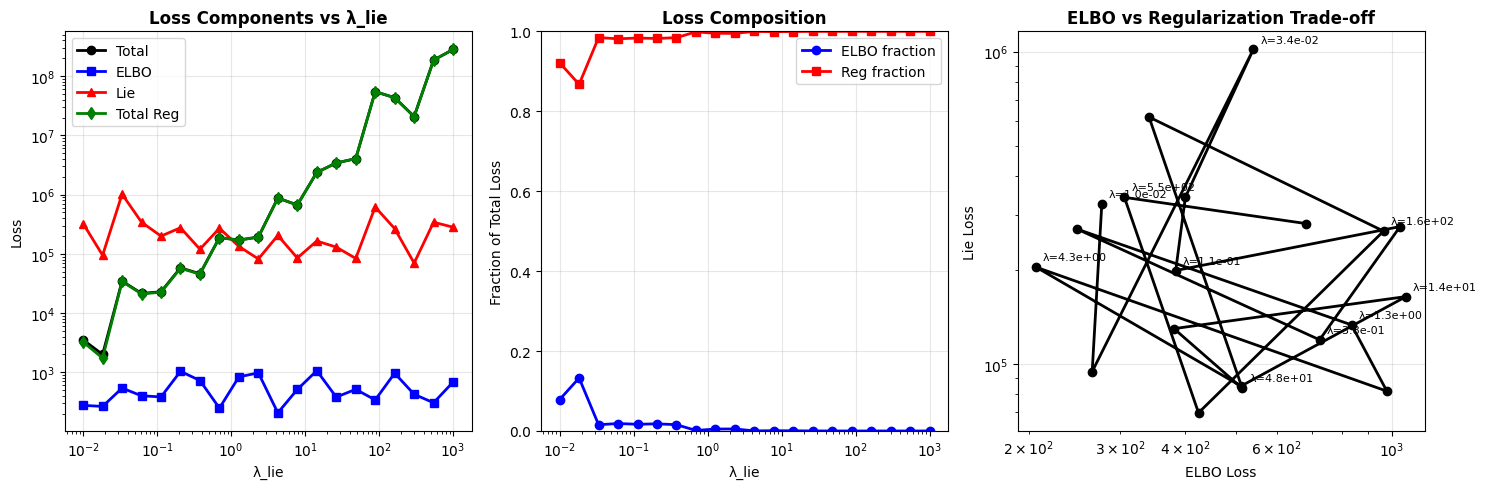

✅ Comprehensive λ sweep completed!


In [16]:
# Comprehensive lambda sweep
lambda_sweep_values = np.logspace(-2, 3, 20)  # 0.01 to 1000

print(f"📊 Comprehensive λ sweep: {len(lambda_sweep_values)} values from {lambda_sweep_values[0]:.3f} to {lambda_sweep_values[-1]:.1f}")

# Use the regularization strength analyzer
strength_analyzer = RegularizationStrengthAnalyzer()

# For speed, use smaller dataset for sweep
y_sweep = y[:100]  # Use 100 trials

# Define SSM factory for sweep
def ssm_factory(lambda_lie):
    return create_regularized_ssm(lambda_lie=lambda_lie)

# Run the sweep
sweep_results = strength_analyzer.sweep_lambda_values(
    lambda_sweep_values, ssm_factory, y_sweep, n_samples=5
)

# Plot results
fig = strength_analyzer.plot_lambda_sweep(save_path='comprehensive_lambda_sweep.png')
plt.show()

print("✅ Comprehensive λ sweep completed!")

## 🎯 Step 10: Find Optimal Lambda

Use different criteria to find the optimal regularization strength.

In [17]:
# Find optimal lambda using different methods
methods = ['target', 'elbow', 'balanced']
target_lie_loss = 1e-3  # Target for "perfect" symmetry

print("🎯 Finding Optimal λ using different criteria:\n")

optimal_results = {}
for method in methods:
    if method == 'target':
        result = strength_analyzer.find_optimal_lambda(target_lie_loss=target_lie_loss, method=method)
    else:
        result = strength_analyzer.find_optimal_lambda(method=method)
    
    optimal_results[method] = result
    
    print(f"{method.capitalize()} method:")
    print(f"   Optimal λ = {result['optimal_lambda']:.3f}")
    print(f"   ELBO loss = {result['analysis']['elbo_loss']:.6f}")
    print(f"   Lie loss = {result['analysis']['lie_loss']:.6f}")
    print(f"   ELBO fraction = {result['analysis']['elbo_fraction']:.3f}")
    print(f"   Reg fraction = {result['analysis']['reg_fraction']:.3f}")
    print()

# Recommend best lambda
target_result = optimal_results['target']
recommended_lambda = target_result['optimal_lambda']

print(f"🎯 RECOMMENDATION:")
print(f"   Use λ_lie = {recommended_lambda:.3f} for near-perfect rotation symmetry")
print(f"   This achieves Lie loss ≈ {target_result['analysis']['lie_loss']:.6f}")
print(f"   While maintaining reasonable ELBO loss")

🎯 Finding Optimal λ using different criteria:

Target method:
   Optimal λ = 297.635
   ELBO loss = 424.278168
   Lie loss = 69739.437500
   ELBO fraction = 0.000
   Reg fraction = 1.000

Elbow method:
   Optimal λ = 0.018
   ELBO loss = 264.868927
   Lie loss = 94485.343750
   ELBO fraction = 0.133
   Reg fraction = 0.867

Balanced method:
   Optimal λ = 0.018
   ELBO loss = 264.868927
   Lie loss = 94485.343750
   ELBO fraction = 0.133
   Reg fraction = 0.867

🎯 RECOMMENDATION:
   Use λ_lie = 297.635 for near-perfect rotation symmetry
   This achieves Lie loss ≈ 69739.437500
   While maintaining reasonable ELBO loss
